In [347]:
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd
import jieba
import torch.utils.data as Data
from torch.nn import functional as F
from torch.optim import lr_scheduler
import math
import os


In [348]:
def to_int(label):
    for i in range(len(label)):
        label[i] = int(label[i])

In [349]:
def to_split(str_list,cut_for_search=False,cut_all=False):
    def to_str(review):
        for i in range(len(review)):
            review[i] = str(review[i])
    to_str(str_list)
    for i in range(len(str_list)):
        if cut_for_search:
            str_split=list(jieba.cut_for_search(str_list[i]))
        else:
            str_split=list(jieba.cut(str_list[i],cut_all=cut_all))
        str_split = pd.Series(str_split)[pd.Series(str_split).apply(len)>0]
        punctuation=[':','“','”',',','…','。','.','~','、','～','......','，',
                     '♪','(',')','o','。。。','……','•','。。。。。。']
        str_split = str_split[~str_split.isin(punctuation)]
        str_list[i]=" ".join(str_split)
    

In [350]:
# a=['傻逼送你妈的货!']
# to_split(a)

# type(a[0])

In [351]:
file1="/root/autodl-tmp/data/评论情感分析数据集/waimai_10k.csv"
file2="/root/autodl-tmp/data/评论情感分析数据集/ChnSentiCorp_htl_all.csv"
data1=pd.read_csv(file1)
data2=pd.read_csv(file2)
f1_review_pos,f1_label_pos=list(data1["review_pos"])[:4000],list(data1["label_pos"])[:4000]
f1_review_neg,f1_label_neg=list(data1["review_neg"])[:7987],list(data1["label_neg"])[:7987]
f2_review_pos,f2_label_pos=list(data2["review_pos"])[:5322],list(data2["label_pos"])[:5322]
f2_review_neg,f2_label_neg=list(data2["review_neg"])[:2444],list(data2["label_neg"])[:2444]
to_split(f1_review_pos)
to_split(f1_review_neg)
to_split(f2_review_pos)
to_split(f2_review_neg)
to_int(f1_label_pos)
to_int(f1_label_neg)
to_int(f2_label_pos)
to_int(f2_label_neg)
train_data=(f1_review_pos[:-500]+f1_review_neg[:-500]+f2_review_pos[:-500]+f2_review_neg[:-500]
            ,f1_label_pos[:-500]+f1_label_neg[:-500]+f2_label_pos[:-500]+f2_label_neg[:-500])
test_data=(f1_review_pos[-500:]+f1_review_neg[-500:]+f2_review_pos[-500:]+f2_review_neg[-500:]
            ,f1_label_pos[-500:]+f1_label_neg[-500:]+f2_label_pos[-500:]+f2_label_neg[-500:])

# test_data[0]

In [352]:
def load_data(batch_size, num_steps=100):
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=2)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size,
                                is_train=True)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

# len(vocab)
# sentence="你 真棒 啊 真的 是 太 厉害 了"
# a=torch.tensor(vocab[sentence.split()])
# a

In [353]:
class ResnetBlock(nn.Module):
    
    def __init__(self, channel_size):
        super(ResnetBlock, self).__init__()

        self.channel_size = channel_size
        self.maxpool = nn.Sequential(
            nn.ConstantPad1d(padding=(0, 1), value=0), # 使用常量来填充输入张量的边界，padding - 填充的数量，value - 要填充的值
            nn.MaxPool1d(kernel_size=3, stride=2)
        )
        self.conv = nn.Sequential( #一个1/2池化的残差块
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1),

            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x_shortcut = self.maxpool(x)
        x = self.conv(x_shortcut)
        x = x + x_shortcut
        return x

In [354]:
class DPCNN(nn.Module):
    
    def __init__(self, max_features, word_embedding_dimension, max_sentence_length, num_classes):
        super(DPCNN, self).__init__()
        self.max_features = max_features 
        self.embed_size = word_embedding_dimension
        self.maxlen = max_sentence_length 
        self.num_classes = num_classes 
        self.channel_size = 250
        self.embedding = nn.Embedding(self.max_features, self.embed_size)
        torch.nn.init.normal_(self.embedding.weight.data, mean=0, std=0.01)
        self.region_embedding = nn.Sequential(
            nn.Conv1d(self.embed_size, self.channel_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_features=self.channel_size), 
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1), 
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1), 
        )
        self.seq_len = self.maxlen
        resnet_block_list = []
        while (self.seq_len > 2):
            resnet_block_list.append(ResnetBlock(self.channel_size))
            self.seq_len = self.seq_len // 2  
        self.resnet_layer = nn.Sequential(*resnet_block_list)
        self.fc = nn.Sequential(
            nn.Linear(self.channel_size * self.seq_len, self.num_classes),
            nn.BatchNorm1d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(self.num_classes, self.num_classes)
        )

    def forward(self, description_word_seq):
        x = self.embedding(description_word_seq)
        x = x.permute(0, 2, 1)
        x = self.region_embedding(x)
        x = self.conv_block(x)
        x = self.resnet_layer(x)
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(x.size(0), -1)
        output = self.fc(x)
        return output
    def predict(self,vocab,sentence,cut_all=False):
       to_split(sentence,cut_all)
       sentence=sentence[0].split()
       if len(sentence)>self.maxlen:
           sentence=sentence[:self.maxlen]
       else:
           sentence=sentence+['<pad>']*(self.maxlen-len(sentence))
       sequence = torch.tensor(vocab[sentence])
       label = torch.argmax(self.forward(sequence.view(1,-1).to(d2l.try_gpu())), dim=1)
       return 'positive' if label.item() == 1 else 'negative'

In [355]:
class TokenEmbedding:
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir='/root/autodl-tmp/data/评论情感分析数据集'
        with open(os.path.join(data_dir, embedding_name), 'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, d2l.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[d2l.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [356]:
word_embedding_dimension,max_sentence_length,num_classes=300,100,2
train_iter,test_iter,vocab=load_data(128,max_sentence_length)
net = DPCNN(len(vocab), word_embedding_dimension, max_sentence_length, num_classes)
glove_embedding = TokenEmbedding('sgns.weibo.word')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

In [ ]:
# for name,params in net.named_parameters():
#     if params.requires_grad:
#         print(name)

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
        warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr


In [ ]:
def train_batch(net, X, y, loss, trainer, device,scheduler=False):
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    if scheduler:
        scheduler.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler=False):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = net.to(device)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, device,scheduler)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
                    
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')

In [ ]:
def train_fine_tuning(net, train_iter, test_iter,lr, num_epochs, loss, device,
                      scheduler=False,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["embedding.weight"]]
        trainer = torch.optim.Adam([{'params': net.embedding.parameters(),'lr': lr * 0.1},
                                    {'params': params_1x}],
                                   lr=lr,weight_decay=0.001)
    else:
        trainer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.001)
        
    if scheduler:
        scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(trainer,T_0=4,T_mult=2)
    train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler)


7.35698368412999e-05
0.000735698368412999


7.137775467151411e-05
0.000713777546715141


6.91341716182545e-05
0.000691341716182545




KeyboardInterrupt: 

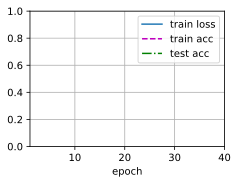

In [ ]:
lr, num_epochs = 1e-3, 40
device=d2l.try_gpu()
loss = nn.CrossEntropyLoss(reduction="none")
# scheduler=CosineScheduler(max_update=40,warmup_steps=10,base_lr=1e-3,final_lr=1e-4)
train_fine_tuning(net, train_iter, test_iter,lr, num_epochs, loss, device,scheduler=True)


In [ ]:
net.predict(vocab=vocab,
            sentence=["你是个哈卵麻批"])

'negative'